# Mean-smoothing filter
Mean-smooth filter is useful if noise is distributed equaly in positive and negative derections around clean signal


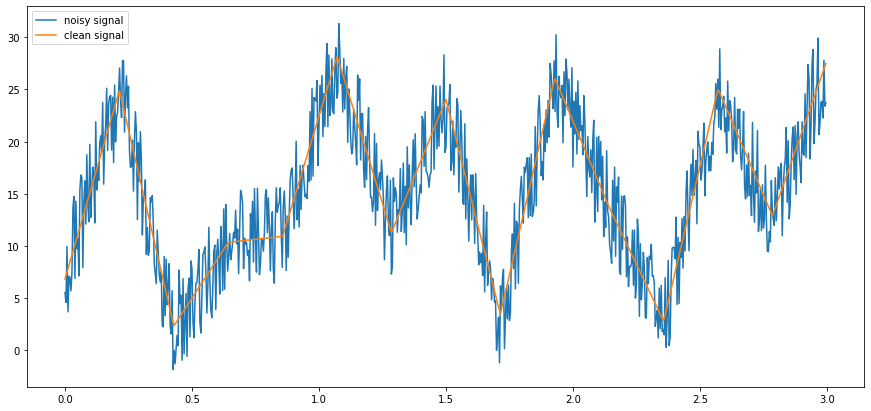

In [68]:
# MEAN-SMOOTHING FILTER

import numpy as np
import matplotlib.pyplot as plt


sampling_rate = 256
time = np.arange(0, 3, 1 / sampling_rate)  # 256 * 3 seconds
n_interpolation_pole = 15  # real number of data points before interpolation
n_data = len(time)  # number of data points after interpolation
data_amplitude = 30
noise_amplitude = 5

clean_signal = np.random.random(n_interpolation_pole) * data_amplitude
clean_signal = np.interp(time, np.linspace(0, 3, n_interpolation_pole), clean_signal)
noise = np.random.uniform(-1, 1, n_data) * noise_amplitude
noisy_signal = clean_signal + noise

plt.figure(figsize=(15, 7))
plt.plot(time, noisy_signal, label='noisy signal')
plt.plot(time, clean_signal, label='clean signal')
plt.legend()


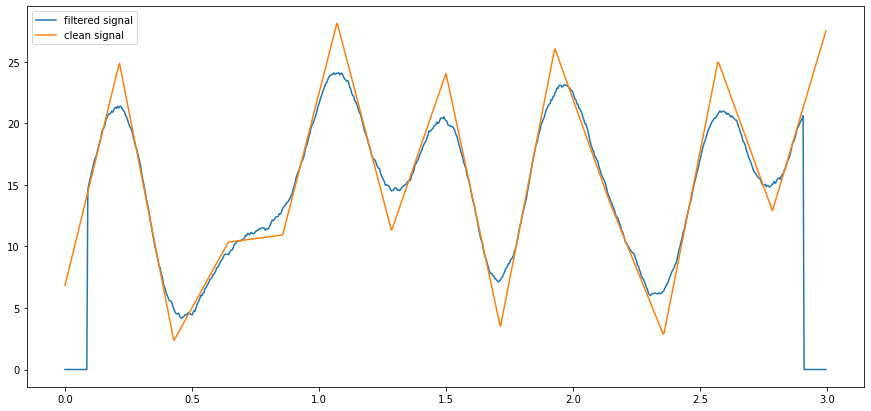

In [69]:

k = 22  # Filter window = k*2+1, the bigger k, the smoother is signal
mean_filtered_signal = np.zeros(n_data)

for i in range(k + 1, n_data - k - 1):
    mean_filtered_signal[i] = np.mean(noisy_signal[i - k:i + k])

plt.figure(figsize=(15, 7))
plt.plot(time, clean_signal, label='clean signal')
plt.plot(time, mean_filtered_signal, label='filtered signal')

plt.legend()


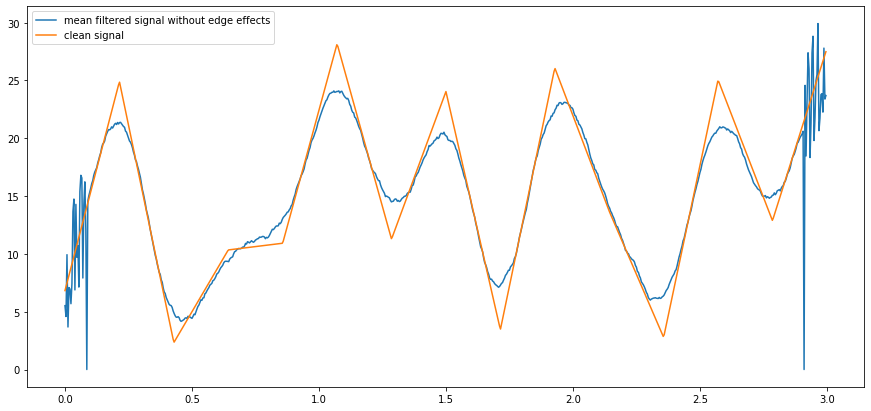

In [70]:
mean_filtered_signal_without_edge_effects = noisy_signal
mean_filtered_signal_without_edge_effects[k:-k] = mean_filtered_signal[k:-k]

plt.figure(figsize=(15, 7))
plt.plot(time, clean_signal, label='clean signal')
plt.plot(time, mean_filtered_signal_without_edge_effects, label='mean filtered signal without edge effects')
plt.legend()

# Gaussian-smoothing filter
Usuall used instead of mean-smoothing filter

Text(0.5, 1.0, 'Gaussian kernel with full_width_half_maximum = 40')

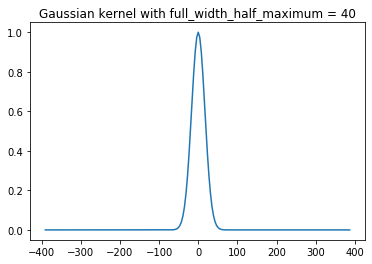

In [71]:
# GAUSSIAN-SMOOTHING FILTER
full_width_half_maximum = 40  # ms, influences width of the 'bell' shape

k = 100  # k should be large enough for the Gaussian curve to touch the x axis on sides
gaussian_time = 1000 * np.arange(-k, k) / sampling_rate
gaussian_window = np.exp(-(4 * np.log(2) * (gaussian_time ** 2)) / full_width_half_maximum ** 2)

plt.plot(gaussian_time, gaussian_window)
plt.title('Gaussian kernel with full_width_half_maximum = %d' % full_width_half_maximum)


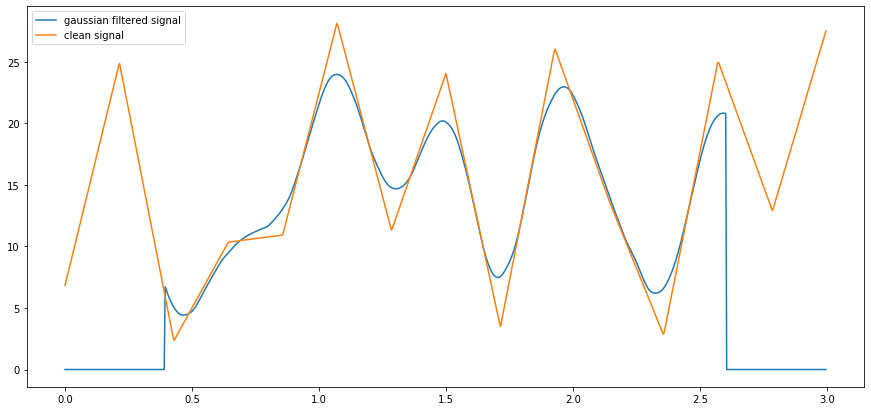

In [72]:
# scaling gaussian_window to the scale of the data (otherwise its amplitude is much larger)
gaussian_window = gaussian_window / sum(gaussian_window)

gaussian_filtered_signal = np.zeros(n_data)

for i in range(k + 1, n_data - k - 1):
    gaussian_filtered_signal[i] = sum(noisy_signal[i - k:i + k] * gaussian_window)

plt.figure(figsize=(15, 7))
plt.plot(time, clean_signal, label='clean signal')
plt.plot(time, gaussian_filtered_signal, label='gaussian filtered signal')
plt.title('Zoomed in version')
plt.legend()

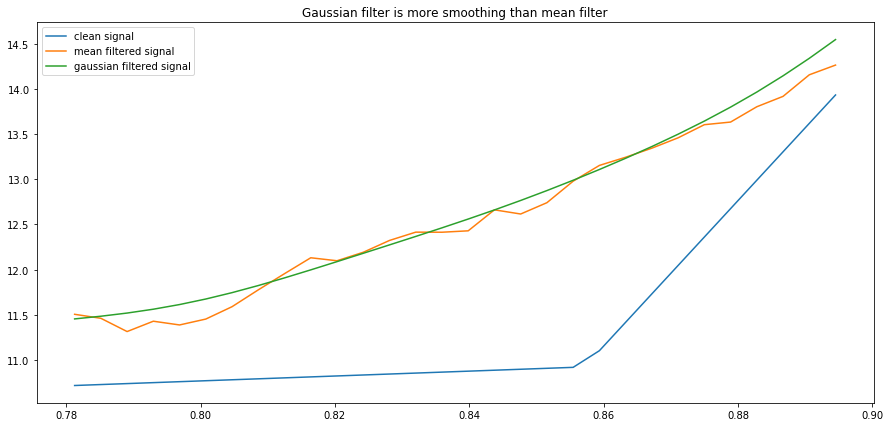

In [82]:
plt.figure(figsize=(15, 7))
plt.plot(time[200:230], clean_signal[200:230], label='clean signal')
plt.plot(time[200:230], mean_filtered_signal[200:230], label='mean filtered signal')
plt.plot(time[200:230], gaussian_filtered_signal[200:230], label='gaussian filtered signal')
plt.title('Gaussian filter is more smoothing than mean filter')
plt.legend()

# Gaussian-Smoothing filter for spikes


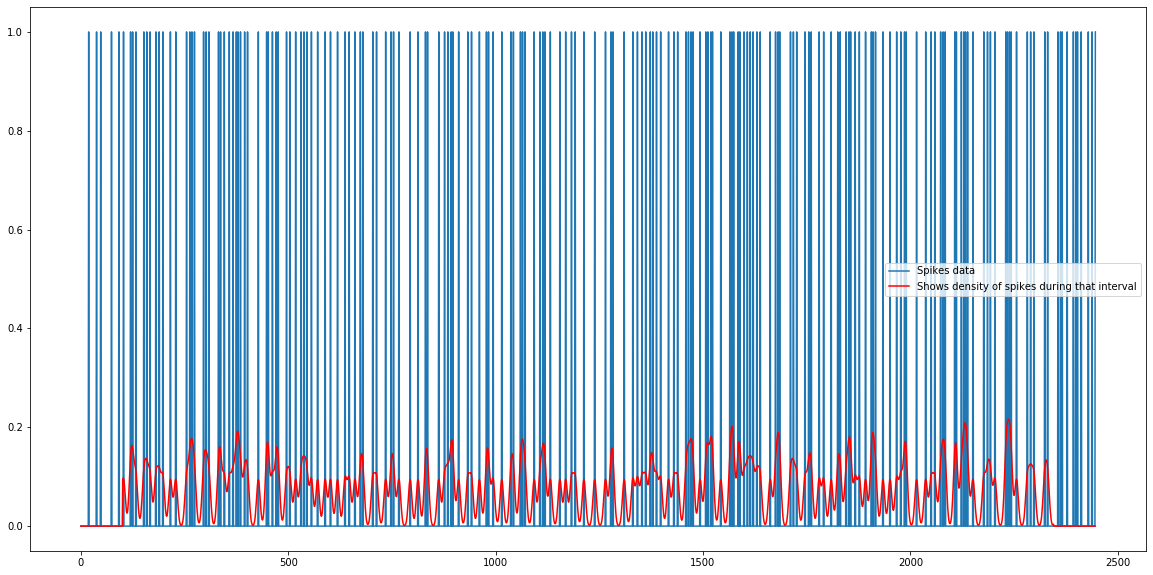

In [107]:
# GAUSSIAN-SMOOTHING FILTER FOR SPIKES

# Data generation

n_spikes = 200

inter_spike_interval = np.round(np.exp(np.random.uniform(-1, 1, n_spikes)) * 10).astype(int)
n_spikes_data = sum(inter_spike_interval) + 1
spikes_signal = np.zeros(n_spikes_data)

data_pointer = 0
for i in range(n_spikes):
    spikes_signal[data_pointer + inter_spike_interval[i]] = 1
    data_pointer += inter_spike_interval[i]

# Gaussian filter 

full_width_half_maximum_s = 10  # ms, influences to what extent spikes will be smoothed out
k = 100  # window size = k*2+1 (data that a single point will be calculated from)
gaussian_time_s = np.arange(-k, k)
gaussian_window_s = np.exp(-(4 * np.log(2) * (gaussian_time_s ** 2)) / full_width_half_maximum_s ** 2)
gaussian_window_s = gaussian_window_s / sum(gaussian_window_s)

gaussian_spike_smoothed_signal = np.zeros(n_spikes_data)
for i in range(k + 1, n_spikes_data - k - 1):
    gaussian_spike_smoothed_signal[i] = sum(spikes_signal[i - k:i + k] * gaussian_window_s)

plt.figure(figsize=(20, 10))
plt.plot(spikes_signal, label='Spikes data')
plt.plot(gaussian_spike_smoothed_signal, label='Shows density of spikes during that interval', color='r')
plt.legend()
